In [ ]:
import os
import glob

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow_hub as hub


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import time
from google.colab import drive

drive.mount('/content/drive')

# classNames = ['Brassica', 'Calendula', 'Cardus', 'Castanea', 'Cistus_sp', 'Citrus_sp', 'Hedysarum', 'Helianthus_annuus', 'Lotus', 'Quercus_sp']

data_dir = '/content/drive/MyDrive/train/'
filepaths = []
class_labels = []
file_list = os.listdir(data_dir)
for file in file_list:
    file_path = os.path.join(data_dir,file)
    filepaths.append(file_path)
    label = file.split('_')[0]
    label = label.replace(' ', '_')
    class_labels.append(label)

test_data_dir = '/content/drive/MyDrive/test/'

file_test = os.listdir(test_data_dir)
test_filepaths = [os.path.join(test_data_dir, file) for file in file_test]

# Create a DataFrame for the test data
test_df = pd.DataFrame(test_filepaths, columns=['filepaths'])

#Create a DataFrame
df_filepath = pd.Series(filepaths, name='filepaths')
df_labels = pd.Series(class_labels, name='labels')
ds = pd.concat([df_filepath, df_labels], axis=1)


# Split the dataset into training and validation train_ds and val_ds
train_ds, val_ds = train_test_split (ds, test_size=0.2, shuffle=True, stratify=ds['labels'])
#train_ds, val_ds = train_test_split (ds, test_size=0.2, shuffle=True, random_state=123, stratify=ds['labels'])
print ('train_df length: ', len(train_ds), '  valid_df length: ', len(val_ds))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train_df length:  2046   valid_df length:  512


In [ ]:
# Create a train_gen,  a valid_gen and a test_gen
img_size=(224,224)
batch_size=32
ds_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
#                                   height_shift_range=.2, zoom_range=.2   )

train_generator = ds_datagen.flow_from_dataframe(
    train_ds,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

val_generator = ds_datagen.flow_from_dataframe(
    val_ds,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size)

test_generator = ds_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col=None,
    target_size=img_size,
    class_mode=None,  # Set to None since you don't have annotations
    shuffle=False  # Set to False to maintain the order of predictions
)

Found 2046 validated image filenames belonging to 10 classes.
Found 512 validated image filenames belonging to 10 classes.
Found 635 validated image filenames.


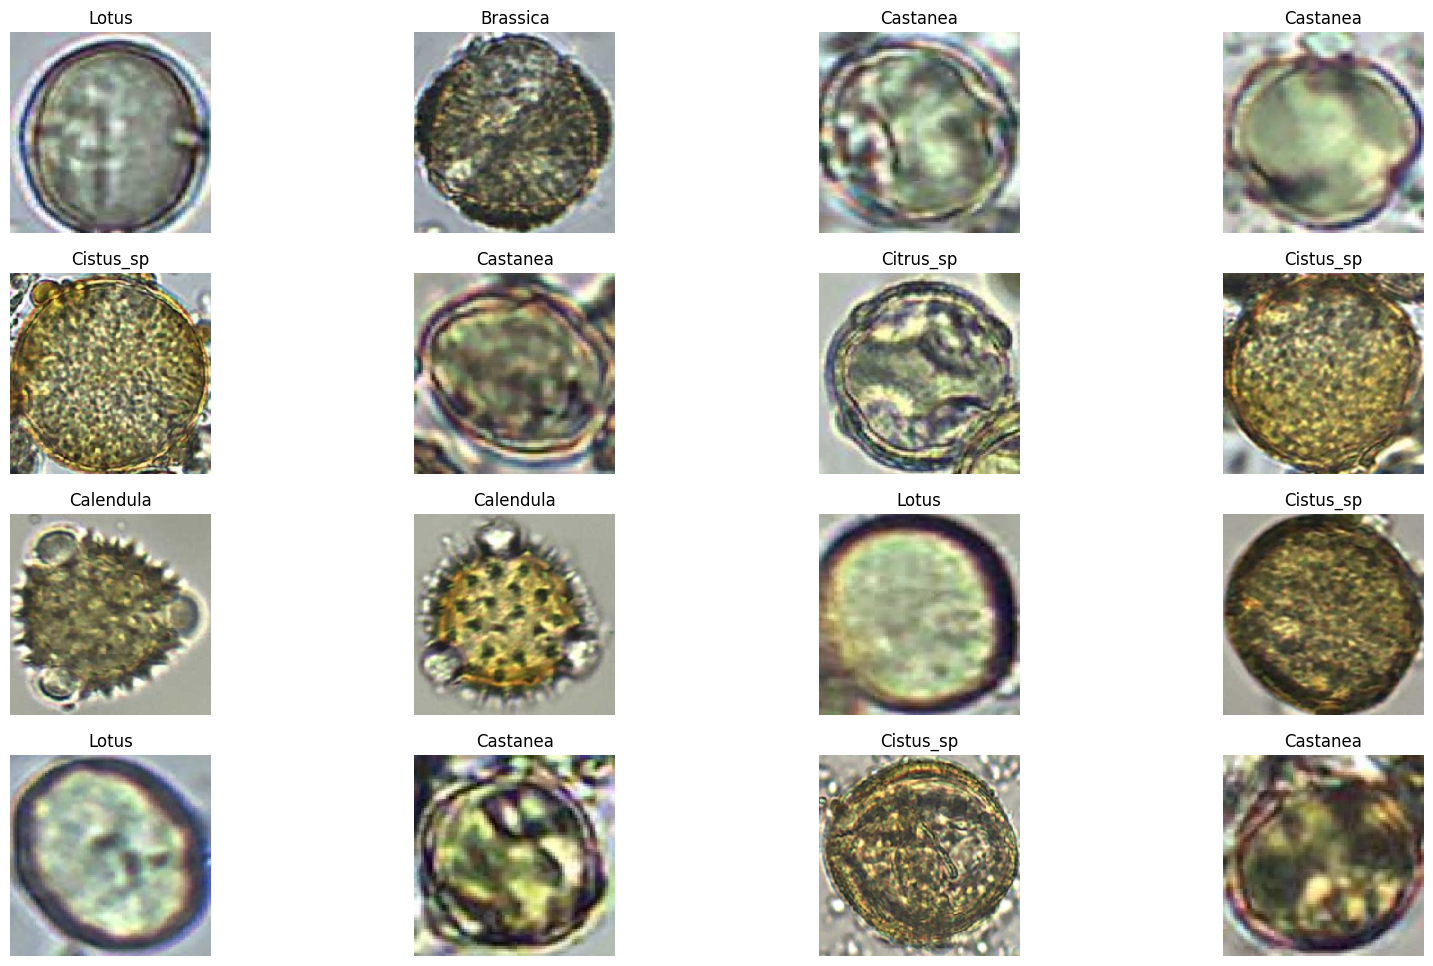

In [ ]:
#Explore the dataset

# Visualize a few images from the training set
train_files=train_generator.filenames
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
labels=train_generator.labels
images, labels=next(train_generator)

plt.figure(figsize=(20, 12))

for i in range (16):
    plt.subplot(4, 4, i+1)
    index=np.argmax(labels[i])
    class_name=classes[index]
    # plt.title(class_name, color='yellow', fontsize=18)
    plt.title(class_name)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
restnet101= "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"
feature_extractor_model = restnet101

# feature_extractor = hub.KerasLayer(URL,
#   input_shape=(IMAGE_RES, IMAGE_RES, 3),
#   trainable=False)

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(10)
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              44677609  
                                                                 
 dense_3 (Dense)             (None, 10)                10020     
                                                                 
Total params: 44687629 (170.47 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


Epoch 1/14
64/64 [==============================] - 39s 406ms/step - loss: 2.2995 - accuracy: 0.2889 - precision_3: 0.1973 - recall_3: 0.5670 - auc_3: 0.6858 - val_loss: 1.5991 - val_accuracy: 0.4238 - val_precision_3: 0.2620 - val_recall_3: 0.7129 - val_auc_3: 0.7862
Epoch 2/14
64/64 [==============================] - 25s 390ms/step - loss: 1.3674 - accuracy: 0.5156 - precision_3: 0.2863 - recall_3: 0.7981 - auc_3: 0.8309 - val_loss: 1.1375 - val_accuracy: 0.5879 - val_precision_3: 0.3074 - val_recall_3: 0.8418 - val_auc_3: 0.8633
Epoch 3/14
64/64 [==============================] - 25s 387ms/step - loss: 1.0257 - accuracy: 0.6334 - precision_3: 0.3190 - recall_3: 0.8915 - auc_3: 0.8779 - val_loss: 0.9152 - val_accuracy: 0.6738 - val_precision_3: 0.3289 - val_recall_3: 0.9102 - val_auc_3: 0.8870
Epoch 4/14
64/64 [==============================] - 25s 393ms/step - loss: 0.8441 - accuracy: 0.6989 - precision_3: 0.3330 - recall_3: 0.9277 - auc_3: 0.8929 - val_loss: 0.7907 - val_accuracy: 

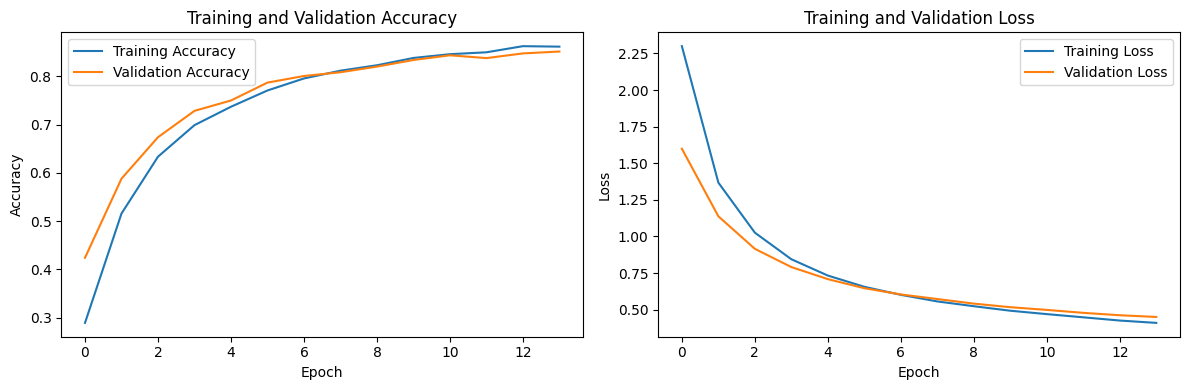

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

# Train the model
history = model.fit(
    train_generator,
    epochs=14,
    validation_data=val_generator,
    callbacks=tensorboard_callback
)

accuracy = model.evaluate(val_generator)
print(f'The model accuracy is {accuracy[1] * 100:0.1f}%')

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
%tensorboard --logdir logs/fit

16/16 [==============================] - 4s 148ms/step


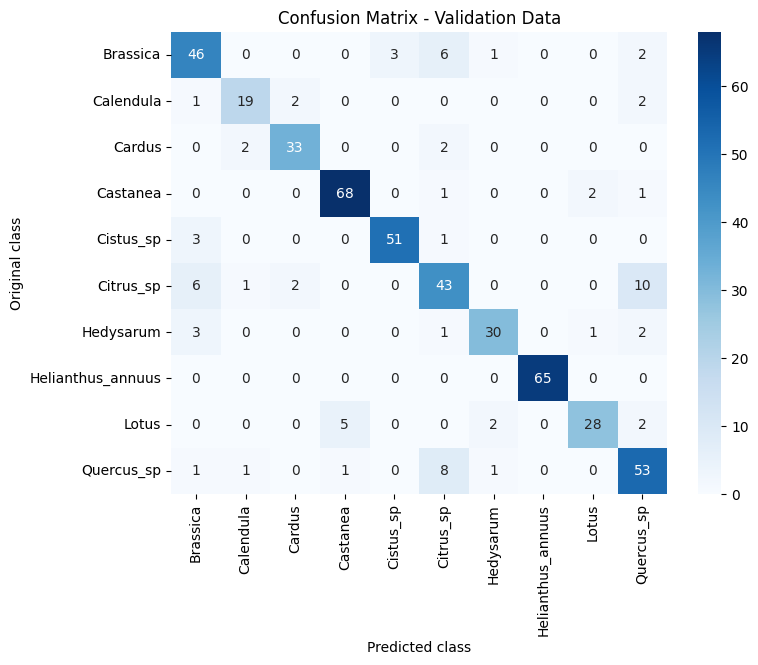

In [ ]:
# Visualize the confusion matrix for validation data
val_true_labels = val_generator.classes
val_predicted_probs = model.predict(val_generator)
val_predicted_labels = np.argmax(val_predicted_probs, axis=1)

# Create the confusion matrix for validation data
conf_mat_val = confusion_matrix(val_true_labels, val_predicted_labels)

classes = train_generator.class_indices.keys()

# Plot the confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_val, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted class')
plt.ylabel('Original class')
plt.show()

20/20 [==============================] - 4s 150ms/step


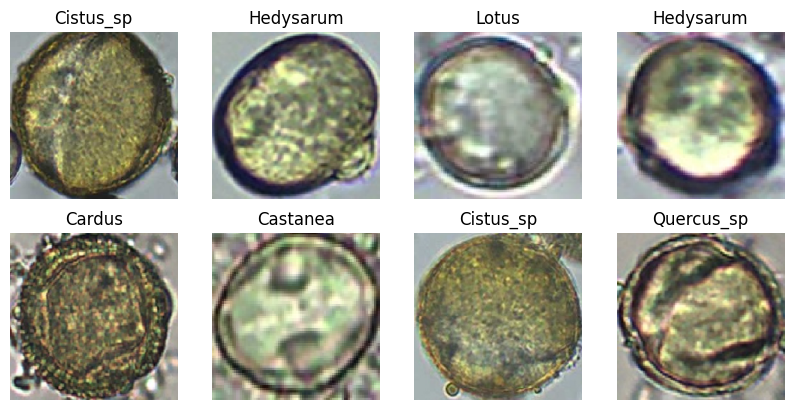

Predictions written to /content/drive/MyDrive/predictions_transferL.txt


In [ ]:
#Make predictions with the test data
predictions = model.predict(test_generator)

#Plot predictions
images = test_generator.next()
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    predicted_class_index = np.argmax(predictions[i])
    predicted_class_name = class_names[predicted_class_index]
    plt.title(predicted_class_name)
    plt.axis('off')

plt.show()

output_file = '/content/drive/MyDrive/predictions_transferL.txt'

#Save predictions to .txt file
with open(output_file, 'w') as file:
    for file_path, prediction in zip(test_filepaths, predictions):
        file_name = os.path.basename(file_path)
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]
        file.write(f'{file_name},{predicted_class_name}\n')

print(f'Predictions written to {output_file}')

In [ ]:
#Save the model
t = time.time()

export_path = "/content/drive/MyDrive/Colab Notebooks/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

# reloaded = tf.keras.models.load_model(export_path)
# result_batch = model.predict(test_generator)
# reloaded_result_batch = reloaded.predict(test_generator)
# abs(reloaded_result_batch - result_batch).max()

# reloaded_predicted_id = np.argmax(reloaded_result_batch, axis=-1)
# reloaded_predicted_label_batch = [classNames[i] for i in reloaded_predicted_id]

# print(reloaded_predicted_label_batch)

# num_images = 30  # Number of images to plot
# num_cols = 5  # Number of columns in the subplot grid
# num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows

# plt.figure(figsize=(12,12))
# # Iterate over the first 30 elements in the test dataset and plot images with predictions
# for i, (image, prediction) in enumerate(zip(test_ds.take(num_images), predictions[:num_images])):
#     predicted_class_index = tf.argmax(prediction)
#     predicted_class_name = classNames[predicted_class_index.numpy()]

#     # Set up the subplot
#     plt.subplot(num_rows, num_cols, i+1)

#     # Display the image
#     plt.imshow(tf.squeeze(image))  # Assuming images are in batch format
#     plt.title(f'P. Class: {predicted_class_name}')
#     plt.axis('off')
#     _ = plt.suptitle("Model predictions")
# # Adjust layout to prevent clipping of titles
# # plt.tight_layout()
# plt.show()

'/content/drive/MyDrive/Colab Notebooks/tmp/saved_models/1700835126'